<a href="https://colab.research.google.com/github/stanimman/Pneumonia-Detection/blob/master/Mura_fast_ai_20_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://fs3.transfernow.net/download/5ddb5139dd8df/master/XR_ELBOW_v1.1.zip

--2019-11-21 11:25:20--  https://fs6.transfernow.net/download/5dce28b2374ba/master/XR_ELBOW_v1.1.zip
Resolving fs6.transfernow.net (fs6.transfernow.net)... 163.172.20.194
Connecting to fs6.transfernow.net (fs6.transfernow.net)|163.172.20.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446968578 (426M) [application/zip]
Saving to: ‘XR_ELBOW_v1.1.zip’

XR_ELBOW_v1.1.zip   100%[===================>] 426.26M  3.01MB/s    in 4m 5s   

2019-11-21 11:29:26 (1.74 MB/s) - ‘XR_ELBOW_v1.1.zip’ saved [446968578/446968578]



In [0]:
!unzip -qq XR_ELBOW_v1.1.zip

In [0]:
from pathlib import Path

In [0]:
path = Path('/content/XR_ELBOW_v1.1')
#import PIL,os,mimetypes
#Path.ls = lambda x: list(x.iterdir())

In [5]:
!git clone https://github.com/fastai/course-v3

Cloning into 'course-v3'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 5303 (delta 17), reused 40 (delta 3), pack-reused 5226
Receiving objects: 100% (5303/5303), 258.04 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (2860/2860), done.


In [0]:
# rm -r /content/exp

In [0]:
mv -T course-v3/nbs/dl2/exp /content/exp

In [0]:
from exp.nb_10b import *
size = 128
tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]
bs = 64
il = ImageList.from_files(path, tfms=tfms)



In [0]:
# Changed the way the data Splitter is fetching the train / valid data split
def parent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

# Changed the way the data labeller is getting the label
def parent_labeler(fn): return fn.parent.name.partition("_")[2]

In [0]:
sd = SplitData.split_by_func(il, partial(parent_splitter, valid_name='valid'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [0]:
ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]
data = ll.to_databunch(bs, c_in=3, c_out=2, num_workers=8)

In [0]:
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)


class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [0]:
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [14]:
x = 5 
z = 10 
if z >5:
  if x >5:
    print(x)
  else:
    print("No")

No


In [0]:
# Add Incorrect Image visualization batches
class IncrctImageCallback(Callback):
	def __init__(self,disp_epoch=None):
		self.disp_epoch = disp_epoch if disp_epoch is not None else 10
		self.disp_counter = 0
		self.train_image,self.valid_image = IncrctImage(True),IncrctImage(False)
		self.train_Incrct_Img_bt,self.valid_Incrct_Img_bt = [],[]
	def begin_epoch(self):
		self.disp_counter += 1
	def after_batch(self):
		if self.disp_counter == self.disp_epoch : 
			self.train_image.accumulate_image(self.run) if self.in_train else self.valid_image.accumulate_image(self.run)
	def after_epoch(self):
		if (self.disp_counter == self.disp_epoch) :
			if (self.in_train): 
				self.train_Incrct_Img_bt = self.train_image.get_image_batch() 
			else:
				self.valid_Incrct_Img_bt = self.valid_image.get_image_batch() 	    			
	def after_fit(self):
		self.logger("Training Image")
		self.train_image.show_batch()
		self.logger("Valid Image")
		self.valid_image.show_batch()

class IncrctImage():
	def __init__(self,Train_phase):
		self.in_train = Train_phase
		self.train_Incrct_Img_bt = {}
		self.valid_Incrct_Img_bt = {}
	def accumulate_image(self,run):
		values, indices =  (F.softmax(run.pred,1)[:,1]  - run.yb).abs().max(0)
		if (self.in_train):
			self.train_Incrct_Img_bt[values] = [run.xb[indices],run.yb[indices]]
		else:
			self.valid_Incrct_Img_bt[values] = [run.xb[indices],run.yb[indices]]
	def get_image_batch(self):
		return [self.train_Incrct_Img_bt[x] for x in sorted(self.train_Incrct_Img_bt.keys(),reverse=True)[:5]] if self.in_train else [self.valid_Incrct_Img_bt[x] for x in sorted(self.valid_Incrct_Img_bt.keys(),reverse=True)[:5]]
	def show_batch(self):
		batch_images_lab = self.get_image_batch()	 	
		plt.figure(figsize=(10,10))
		for n in range(len(batch_images_lab)):
		  ax = plt.subplot(5,5,n+1)
		  plt.imshow(batch_images_lab[n][0].permute(1, 2, 0).type(torch.uint8).cpu())
		  #plt.title(batch_images_lab[n][1])
		  plt.axis('off')

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback, CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),partial(IncrctImageCallback,24)
#         partial(MixUp, alpha=0.2)
       ]

In [0]:
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=2)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

In [0]:
def model_summary(model, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [52]:
learn.model = learn.model.cuda()
model_summary(learn.model, data, print_mod=False)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 2])


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
arch = partial(xresnet34, c_out=2)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [55]:
learn.fit(3, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.763145,0.581829,40370685630.486023,0.494624,00:30


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

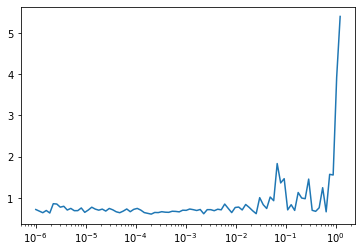

In [56]:
learn.recorder.plot(3)

In [0]:
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [58]:
print(create_phases(0.3))
print(create_phases([0.3,0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [0]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [0]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)]

In [0]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.488178,0.808761,0.502355,0.800000,00:30
1,0.484804,0.815250,0.494380,0.810753,00:30
2,0.486675,0.808152,0.522476,0.797849,00:30
3,0.486381,0.812817,0.496282,0.821505,00:30
4,0.490318,0.808761,0.511836,0.797849,00:30
5,0.493847,0.805111,0.525468,0.776344,00:30
6,0.503077,0.798418,0.524470,0.791398,00:30
7,0.503357,0.799229,0.521216,0.774194,00:30
8,0.510166,0.788887,0.572340,0.746237,00:30
9,0.529882,0.781180,0.545679,0.731183,00:30


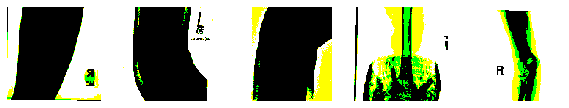

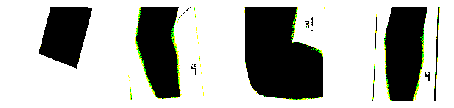

In [64]:
learn.fit(48, cbs=cbsched)

In [0]:
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,accuracy)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [0]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [34]:
learn.fit(25, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.676762,0.585074,0.683741,0.520430,00:30
1,0.660819,0.611843,0.677414,0.537634,00:30
2,0.658162,0.615697,0.672047,0.604301,00:30
3,0.650957,0.634962,0.663060,0.621505,00:30
4,0.645908,0.648753,0.666021,0.600000,00:30
5,0.639478,0.648956,0.641691,0.653763,00:30
6,0.632996,0.663963,0.643935,0.643011,00:30
7,0.627025,0.677550,0.637038,0.658065,00:30
8,0.619194,0.673900,0.633877,0.668817,00:30
9,0.614332,0.681809,0.627541,0.673118,00:30


In [0]:
import torch
import torch.nn.functional as F

In [36]:
torch.sigmoid(torch.tensor([1.0,2.0,-5.0],))[2] #- torch.tensor(1.0)

tensor(0.0067)

In [0]:
input = torch.tensor([1.0,2.0,-5.0])
output = F.softmax(input,0)
values, indices = output.max(0)

In [0]:
max_dict1 = {values : indices}


In [0]:
input = torch.tensor([17.0,10.0,15.0])
output = F.softmax(input,0)
values, indices = output.max(0)

In [40]:
output[0]

tensor(0.8801)

In [41]:
max_dict.keys()

NameError: ignored

In [0]:
max_dict2 = {values : indices}

In [0]:
output[0]

In [0]:
max_dict,max_dict2

In [0]:
final_dict = {}
final_dict[values] = indices

In [0]:
final_dict[values] = indices

In [0]:
final_dict

In [0]:
for key in sorted(final_dict,reverse=True):
  print(key,final_dict[key])

In [0]:
tens